In [9]:
import pandas as pd
import langid
from tqdm.auto import tqdm
tqdm.pandas()

## Langid

In [2]:
langid.set_languages(['uk', 'ru'])

In [5]:
uk_geo_light = pd.read_csv("../data/uk_geo_dataset_light.csv")
ru_geo_light = pd.read_csv("../data/ru_geo_dataset_light.csv")

In [14]:
uk_geo_light['lang'] = 'uk'
ru_geo_light['lang'] = 'ru'
geo_light = pd.concat([uk_geo_light, ru_geo_light]).reset_index(drop=True)

In [22]:
geo_light['lang_pred'] = geo_light['text'].progress_apply(lambda x: langid.classify(x)[0])

  0%|          | 0/220000 [00:00<?, ?it/s]

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

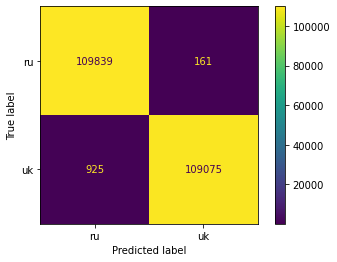

In [24]:
ConfusionMatrixDisplay.from_predictions(geo_light['lang'], geo_light['lang_pred'])

In [26]:
accuracy_score(geo_light['lang'], geo_light['lang_pred'])

0.9950636363636364

In [36]:
wrong = (geo_light[geo_light['lang'] != geo_light['lang_pred']]).copy()
wrong

,text,loc_markers,is_valid,lang,lang_pred
270,Кирило Шевченко перебуватиме у США упродовж 8-...,"[(31, 34)]",0,uk,ru
402,Серед найпоширеніших видів рослинного молока —...,[],0,uk,ru
560,Потім суддя отримає дзвінок із приблизно насту...,[],0,uk,ru
906,"«В основному люди просто не мають бажання, – г...",[],0,uk,ru
1021,У соборі Святого Павла зібралися 2650 гостей.,[],0,uk,ru
...,...,...,...,...,...
216299,Программу Каннского кинофестиваля в 2013 году ...,[],0,ru,uk
217677,Митинги 5 марта.,[],0,ru,uk
217778,"Мужчину, напавшего на пассажира лондонской под...",[],0,ru,uk
218673,Певица Кортни Лав завершила работу над своими ...,[],0,ru,uk


In [37]:
wrong['num_loc'] = wrong['text'].apply(len)

In [38]:
wrong.loc[560].text

'Потім суддя отримає дзвінок із приблизно наступним текстом: «добрый день, это вас из МГБ ДНР (варіанти: МВД ЛНР, ФСБ РФ) беспокоят.'

In [32]:
wrong.loc[270].text

'Кирило Шевченко перебуватиме у США упродовж 8-13 листопада.'

Приклад `402` цікавий, бо в ньому зрозуміти, що це українська, можна просто по входженню літер "є", "і". Це наводить на думку, що роспізнавання можна зробити трошки краще. Це може бути критичним, бо на тестовому сеті також є міскласифіковані семли, де по ідеї складнощей не мало б виникати

In [34]:
wrong.loc[402].text

'Серед найпоширеніших видів рослинного молока — соєве, рисове, мигдальне та кокосове.'

In [39]:
wrong[wrong['lang_pred'] == 'ru']

,text,loc_markers,is_valid,lang,lang_pred,num_loc
270,Кирило Шевченко перебуватиме у США упродовж 8-...,"[(31, 34)]",0,uk,ru,59
402,Серед найпоширеніших видів рослинного молока —...,[],0,uk,ru,84
560,Потім суддя отримає дзвінок із приблизно насту...,[],0,uk,ru,131
906,"«В основному люди просто не мають бажання, – г...",[],0,uk,ru,64
1021,У соборі Святого Павла зібралися 2650 гостей.,[],0,uk,ru,45
...,...,...,...,...,...,...
109512,"Але якщо мама каже ""ні"", то Аня робить ""так"".",[],1,uk,ru,45
109578,"Постійно якась хе - я: то пташиний грип, то ще...",[],1,uk,ru,54
109636,"Байдуже, головне – вона пила каву, пише “",[],1,uk,ru,41
109675,Тоді в Раду пройшли 64 особи за списками БПП.,[],1,uk,ru,45


In [42]:
wrong[wrong['lang_pred'] == 'ru']['text'].str.contains("і").sum()

567

## Modified langid

In [45]:
import re

In [54]:
def contains_uk_letters(input_string):
    ukrainian_letters = "їієґ`"
    ukrainian_letters_uppercase = ukrainian_letters.upper()
    pattern = re.compile(f"[{ukrainian_letters}{ukrainian_letters_uppercase}]")
    return bool(pattern.search(input_string))

In [55]:
geo_light['lang_pred_mod'] = geo_light.apply(lambda row: 'uk' if contains_uk_letters(row['text']) else row['lang_pred'], axis=1)

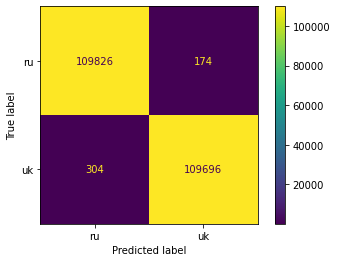

In [56]:
ConfusionMatrixDisplay.from_predictions(geo_light['lang'], geo_light['lang_pred_mod'])

In [57]:
wrong = (geo_light[geo_light['lang'] != geo_light['lang_pred_mod']]).copy()
wrong

,text,loc_markers,is_valid,lang,lang_pred,lang_pred_mod
270,Кирило Шевченко перебуватиме у США упродовж 8-...,"[(31, 34)]",0,uk,ru,ru
906,"«В основному люди просто не мають бажання, – г...",[],0,uk,ru,ru
1313,"Все, що зверх того, – додатки, “бонуси”.",[],0,uk,ru,ru
2627,"Але було це давно, коли хлопець ще був маленьк...",[],0,uk,ru,ru
3227,"“Можливо, я буду покараний”, – сказав пан Крищ...",[],0,uk,ru,ru
...,...,...,...,...,...,...
216299,Программу Каннского кинофестиваля в 2013 году ...,[],0,ru,uk,uk
217677,Митинги 5 марта.,[],0,ru,uk,uk
217778,"Мужчину, напавшего на пассажира лондонской под...",[],0,ru,uk,uk
218673,Певица Кортни Лав завершила работу над своими ...,[],0,ru,uk,uk


In [59]:
wrong.loc[3227].text

'“Можливо, я буду покараний”, – сказав пан Крищенко.'

In [66]:
wrong.sample(20, random_state=42)

,text,loc_markers,is_valid,lang,lang_pred,lang_pred_mod
212758,Нижняя палата парламента Таджикистана приняла ...,"[(25, 37)]",0,ru,uk,uk
15448,"Я трохи засмутилася, але тут на мене чекав сюр...",[],0,uk,ru,ru
53472,Ще такого не бачив на кыльцях обтягнули стрычк...,[],0,uk,ru,ru
30799,Про це пише американське видання The Washingto...,[],0,uk,ru,ru
31911,"Очевидно, що то була лише спроба блефувати.",[],0,uk,ru,ru
46311,Принцеса Шарлота та принц Джордж перед школою ...,[],0,uk,ru,ru
100530,"Те саме з морквою, яблуками, квашеною капустою.",[],1,uk,ru,ru
68955,"Я не встигаю за цим пухнастим"", - написала ""хо...",[],0,uk,ru,ru
94854,"У мене перед очима картинка Тимошенко-Ющенко, ...",[],0,uk,ru,ru
5449,"Хоча це й прикро, але таким не вбити мене.",[],0,uk,ru,ru


In [65]:
for i, text in enumerate(wrong.sample(20, random_state=42).text):
    print(i, text)

0 Нижняя палата парламента Таджикистана приняла законопроект об амнистии.
1 Я трохи засмутилася, але тут на мене чекав сюрприз!
2 Ще такого не бачив на кыльцях обтягнули стрычкоми замысть того аби залатати.
3 Про це пише американське видання The Washington Post.
4 Очевидно, що то була лише спроба блефувати.
5 Принцеса Шарлота та принц Джордж перед школою - фото - Гламур - TCH.
6 Те саме з морквою, яблуками, квашеною капустою.
7 Я не встигаю за цим пухнастим", - написала "холостячка".
8 У мене перед очима картинка Тимошенко-Ющенко, Ющенко-Тимошенко.
9 Хоча це й прикро, але таким не вбити мене.
10 Universal Home Entertainment намерена переиздать на DVD знаменитую кинотрилогию Роберта Земекиса ″Назад в будущее″.
11 На западе Казахстана микроавтобус "Опель" столкнулся с верблюдом.
12 "Уперше Марш слави УПА ми провели 2005 року.
13 Митинги 5 марта.
14 Саме там апостолам з'явився воскреслий Христос.
15 В Москве женщина на розовом Jaguar задавила мужчину на пешеходном переходе.
16 А тому той,

## Lang detection on test

In [67]:
df_test = pd.read_csv("../data/nlp-ua-locations-extractions/test.csv")

In [69]:
df_test['lang_pred'] = df_test['text'].progress_apply(lambda x: langid.classify(x)[0])

  0%|          | 0/477 [00:00<?, ?it/s]

In [73]:
df_test['lang_pred_mod'] = df_test.apply(lambda row: 'uk' if contains_uk_letters(row['text']) else row['lang_pred'], axis=1)

In [74]:
df_test[df_test['lang_pred'] == 'ru']

,text_id,text,locations,lang_pred,lang_pred_mod
6,6,👀\n\nМожемо БПЛА прислати 😀\n\nПсков бомбить Б...,[],ru,ru
15,15,Ще летить,[],ru,ru
27,27,👂Хотим тестить экофлоу и старлинк.,[],ru,ru
29,29,👂На Дмитровской по старой схеме ликвидировали ...,[],ru,ru
31,31,Горит заброшенный полуразвалившийся дом\n\nСоо...,[],ru,ru
53,53,С 28 августа в Белоцерковской общине алкоголь ...,[],ru,ru
54,54,"В Лаврі обирають нового Папу, чи настоятеля?",[],ru,uk
57,57,Найдена собака <корге> забежала в маршрутку на...,[],ru,ru
84,84,Так подготовили укрытие к 1 сентября в Национа...,[],ru,ru
94,94,"На днях наши бойцы из ЗРК ""Стингер"" сбили крыл...",[],ru,ru


## ToDo

Можливо має сенс натрунвати / зафайнтюнити модель, націлену тільки на розрізняння української і російської. Це може спрацювати краще, ніж модель що тренувалась на сеті з десятків різних мов і не враховує вузькі попарні відмінності.